In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pymc3

import bletl
import calibr8
import cutisplit
import retl
import robotools

import run_analysis


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc 4.0
calibr8 6.0.3


In [21]:
DCS_EXPERIMENT = 'Pahpshmir_MTP-Screening-PETase'
RUN_ID = "BZP1XQ"
analyser = run_analysis.CutisplitAnalysis(DCS_EXPERIMENT, RUN_ID)
resultpath = f'{RUN_ID}_Results' 
if not os.path.isdir(resultpath):
    os.makedirs(resultpath)
df_calibration1 = analyser.get_df_calibration(repetition=1)
df_calibration2 = analyser.get_df_calibration(repetition=2)

To translate between absorbance readings and product concentration, the model needs a `calibr8` calibration model for p-Nitrophenol absorbance/concentration.

In [22]:
RUN_ID = "BWNZ99"
analyser = run_analysis.CutisplitAnalysis(DCS_EXPERIMENT, RUN_ID)
resultpath = f'{RUN_ID}_Results' 
if not os.path.isdir(resultpath):
    os.makedirs(resultpath)
df_calibration3 = analyser.get_df_calibration(repetition=1)
df_calibration4 = analyser.get_df_calibration(repetition=2)


In [23]:
independent = numpy.concatenate([
    df_calibration1.dropna().concentration.values,
    df_calibration2.dropna().concentration.values,
    df_calibration3.dropna().concentration.values,
    df_calibration4.dropna().concentration.values,
    
    
])
dependent = numpy.concatenate([
    df_calibration1.dropna().absorbance.values,
    df_calibration2.dropna().absorbance.values,
    df_calibration3.dropna().absorbance.values,
    df_calibration4.dropna().absorbance.values,
    
])
#For splines, no x value can be measured twice, so we add a tiny offset
# mask = numpy.argsort(independent)
# independent = independent[mask]
# dependent = dependent[mask]
# independent = independent + numpy.linspace(0, 0.0001, len(dependent))

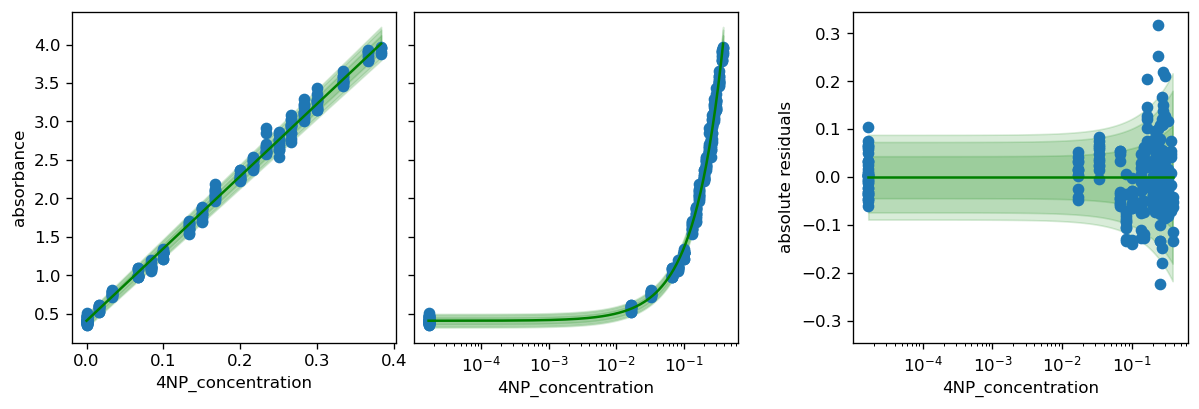

In [25]:
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel()
theta_fit, _ = calibr8.fit_scipy(
    model=cm_nitrophenol,
    independent=independent,
    dependent=dependent,
    theta_guess=[0.5, 2, 0.1, 0.1, 30],
    theta_bounds=[
        (0.001, 50)
    ] * len(cm_nitrophenol.theta_names)
)
cm_nitrophenol.save(fr"{resultpath}\{RUN_ID}_cm_nitrophenol.json")

fig, axs = calibr8.plot_model(cm_nitrophenol)

pyplot.show()

## Alternative spline-based model

In [17]:
spline = bletl.get_crossvalidated_spline(
    x=independent,
    y=dependent,
    bounds=(0, 0.15),
    method="ucss"
)

cmodel = cutisplit.SplineCalibration()
cmodel.set_spline(spline)
calibr8.fit_scipy(
    cmodel,
    independent=independent,
    dependent=dependent,
    theta_guess=[0.01, 0.1, 3],
    theta_bounds=[
        (0.01, 0.5),
        (0.001, 1),
        (1, 30),
    ]
)
calibr8.plot_model(cmodel)
cmodel.save(fr"{resultpath}\{RUN_ID}_cm_nitrophenol-spline.json")

RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

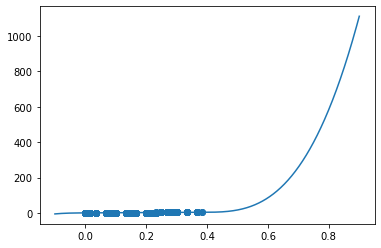

In [8]:
x_dense = numpy.linspace(-0.1,0.9,1000)
pyplot.plot(x_dense, spline(x_dense))
pyplot.scatter(independent, dependent)